In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from utils import *
from scipy import stats

In [2]:
def toep(d, corr_rate):
    a = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            a[i, j] = corr_rate ** abs(i - j)
    return a

def generate_X(n, d, skew=0, cov_vector=None, mu_vector=None):

    if d != 2:
        raise ValueError("Only d=2 is supported")

    if cov_vector is None:
        cov_vector = np.ones(d)

    X = np.zeros((n, d))
    X[:,0] = np.random.normal(0, cov_vector[0], n)
    X[:, 1] = stats.skewnorm.rvs(skew, size=n, loc=0, scale=cov_vector[1])
    X[:,1] = X[:,1] - np.mean(X[:,1])

    if mu_vector is not None:
        X = X + mu_vector

    return X

def get_y_prob_bayes_independent(Xobs, mask, cov_vector, skew_mis, true_beta, n_mc=1000, intercept=0):

    M = np.isnan(Xobs)
    
    # Preallocate result array
    prob_y_all = np.zeros((Xobs.shape[0]))

    # Pattern 01:
    idx_01 = np.where(np.all(M == [0,1], axis=1))[0]
    prob_y_all[idx_01] = get_y_prob_bayes_pattern_01(Xobs[idx_01, 0], cov_vector[1], skew_mis, true_beta, n_mc=n_mc, intercept=intercept)

    # pattern 10:
    idx_10 = np.where(np.all(M == [1,0], axis=1))[0]
    prob_y_all[idx_10] = get_y_prob_bayes_pattern_10(Xobs[idx_10, 1], cov_vector[0], 0, true_beta, n_mc=n_mc, intercept=intercept)

    # pattern 11:
    idx_11 = np.where(np.all(M == [1,1], axis=1))[0]
    prob_y_all[idx_11] = get_y_prob_bayes_pattern_11(Xobs[idx_11], cov_vector, skew_mis, true_beta, n_mc=n_mc, intercept=intercept)

    idx_00 = np.where(np.all(M == [0,0], axis=1))[0]
    if len(idx_00) > 0:
        logits = np.dot(Xobs[idx_00], true_beta) + intercept
        prob_y_all[idx_00] = 1 / (1 + np.exp(-logits))

    return prob_y_all

def get_y_prob_bayes_pattern_01(Xobs, scale_mis, skew_mis, true_beta, n_mc=1000, intercept=0):

    # Generate n_mc samples from Distribution of Missing Values
    X_MISS = stats.skewnorm.rvs(skew_mis, size=(n_mc, 1), loc=0, scale=scale_mis)
    X_MISS = X_MISS - np.mean(X_MISS, axis=0)

    logits_1 = Xobs * true_beta[0]
    logits_2 = X_MISS * true_beta[1]

    logits = logits_1 + logits_2 + intercept

    probs = 1 / (1 + np.exp(-logits))

    probs_bayes = np.mean(probs, axis=0)

    return probs_bayes

def get_y_prob_bayes_pattern_10(Xobs, scale_mis, skew_mis, true_beta, n_mc=1000, intercept=0):

    # Generate n_mc samples from Distribution of Missing Values
    X_MISS = np.random.normal(0, scale_mis, size=(n_mc, 1))

    logits_1 = X_MISS * true_beta[0]
    logits_2 = Xobs * true_beta[1]

    logits = logits_1 + logits_2 + intercept

    probs = 1 / (1 + np.exp(-logits))

    probs_bayes = np.mean(probs, axis=0)

    return probs_bayes

def get_y_prob_bayes_pattern_11(Xobs, cov_vector, skew_mis, true_beta, n_mc=1000, intercept=0):

    X_gen = generate_X(n=n_mc, d=2, skew=skew_mis, cov_vector=cov_vector)
    y_logits = np.dot(X_gen, true_beta) + intercept
    y_probs = 1 / (1 + np.exp(-y_logits))

    probs_bayes = np.mean(y_probs)

    # repeat for all MC samples
    probs_bayes = np.repeat(probs_bayes, Xobs.shape[0])

    return probs_bayes


In [3]:
# Define the percentages of missingness and number of replicates

experiment_name = "ExpF"
experiment_data_folder = os.path.join("data", experiment_name)

if os.path.exists(experiment_data_folder) == False:
    os.makedirs(experiment_data_folder)

if os.path.exists(os.path.join(experiment_data_folder, "original_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "original_data"))

if os.path.exists(os.path.join(experiment_data_folder, "test_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "test_data"))

if os.path.exists(os.path.join(experiment_data_folder, "pred_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "pred_data"))

if os.path.exists(os.path.join(experiment_data_folder, "bayes_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "bayes_data"))


missingness_percentages = [0.35]
n_replicates = 1
Ds = [2]
n_train = 500000
n_test = 15000
n = n_train + n_test

cov_vector = np.array([9,2]) / 2
mu_vector = np.array([8,0]) / 2
skew = 0


print("# of setups = ", n_replicates * len(missingness_percentages))

N_MC = 15000

# The set-up dataframe should contain:
# - rep
# - n
# - trueProp1
# - true_beta
# - center_X
# - set_up (name)
# [The rest will be part of **kwargs throughout the code]

df_set_up = pd.DataFrame({
    "rep":[],
    "n":[],
    "true_beta": [],
    "set_up": [],
    "d":[],
}).T

# np.random.seed(1)
# random.seed(1)

for rep in range(n_replicates):
    print("REP", rep)
    for d in Ds:

        beta0 = np.array([-0.78607419,  1.44814029])*1.5
        # beta0 = np.array([-0.5,1])

        X_full = generate_X(n=n, d=d, skew=skew, cov_vector=cov_vector, mu_vector=mu_vector)
        y_probs = sigma(X_full @ beta0)
        y = np.random.binomial(n=1, p=y_probs)
        
        for prc in missingness_percentages:

            prc_str = str(prc).replace(".", "")
            set_up = f"LOG_n{n}_d{d}_prcNA{prc_str}_rep{rep}"

            M = generate_mask(n, d, prc) # don't allow fully missing
            
            X_obs = X_full.copy()
            X_obs[M == 1] = np.nan


            new_row = pd.Series({
                "rep":rep,
                "n":n,
                "d":d,
                "prcNA":prc,
                "true_beta":beta0,
                "set_up":set_up
            })

            df_set_up = pd.concat([df_set_up, new_row], axis=1, ignore_index=True)

            data_to_save = {
                "X_obs": X_obs,
                "M": M,
                "y": y,
                "y_probs": y_probs,
                "X_full": X_full
            }

            # save
            np.savez(os.path.join(experiment_data_folder, "original_data", f"{set_up}.npz"), **data_to_save)

            # test data
            X_test = X_obs[n_train:]
            y_test = y[n_train:]
            y_probs_test = y_probs[n_train:]
            M_test = M[n_train:]
            data_to_save_test = {
                "X_obs": X_test,
                "M": M_test,
                "y": y_test,
                "y_probs": y_probs_test,
                "X_full": X_full[n_train:]
            }
            np.savez(os.path.join(experiment_data_folder, "test_data", f"{set_up}.npz"), **data_to_save_test)

            # bayes
            y_probs_bayes = y_bayes = get_y_prob_bayes_independent(X_test, M, cov_vector, skew_mis=skew, true_beta=beta0, n_mc=N_MC, intercept=0)

            data_to_save_bayes = {
                "y_probs_bayes": y_probs_bayes
            }

            np.savez(os.path.join(experiment_data_folder, "bayes_data", f"{set_up}.npz"), **data_to_save_bayes)


                    
# save df set-up
df_set_up.T.to_csv(os.path.join(experiment_data_folder, "set_up.csv"), index=False)

# of setups =  1
REP 0


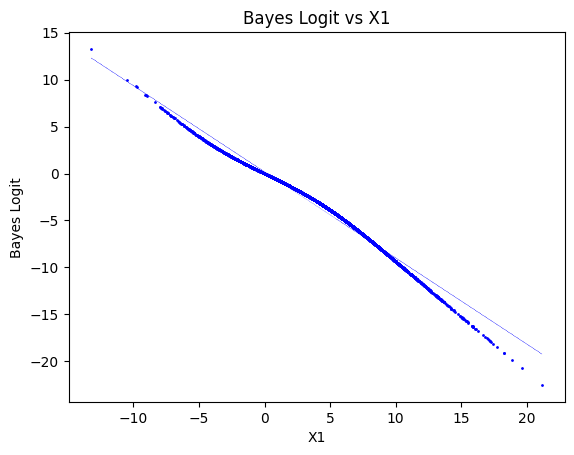

In [4]:
bayes = load_data("LOG_n515000_d2_prcNA035_rep0", "bayes", "ExpF")
test = load_data("LOG_n515000_d2_prcNA035_rep0", "test", "ExpF")
M = test["M"]
X = test["X_obs"]
idx = get_index_pattern([0,1], M)

bayes_clipped = np.clip(bayes["y_probs_bayes"],1e-15, 1-1e-15)
bayes_logit = np.log(bayes_clipped/ (1 - bayes_clipped))

plt.scatter(X[:,0][idx], bayes_logit[idx], s=1, color="blue");
from scipy.stats import linregress
lr = linregress(X[:,0][idx], bayes_logit[idx])
plt.plot(X[:,0][idx], lr.slope * X[:,0][idx] + lr.intercept, color="blue", linewidth=0.2, linestyle="--")
plt.xlabel("X1")
plt.ylabel("Bayes Logit")
plt.title("Bayes Logit vs X1")
plt.show()

0.28835728155339807
0.2167242718446602
0.13761553398058252
0.08444271844660194


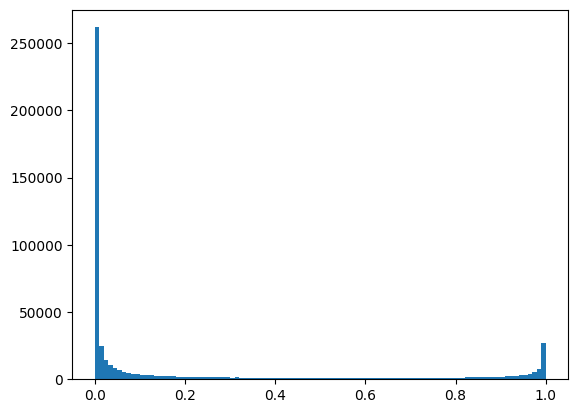

In [5]:
all = load_data("LOG_n515000_d2_prcNA035_rep0", "original", "ExpF")
probs = all["y_probs"]
plt.hist(probs, bins=100);
print(np.mean((probs > 0.05) & (probs < 0.95)))
print(np.mean((probs > 0.1) & (probs < 0.9)))
print(np.mean((probs > 0.2) & (probs < 0.8)))
print(np.mean((probs > 0.3) & (probs < 0.7)))